<div style="text-align: center;">
    <h1> <font style="bold"> TD VI: Inteligencia Artificial </font></h1>
    <h2><font style="bold">Trabajo práctico 2 </font></h2>
    <h3><font style="bold">Integrantes:</font></h3>
</div>
<div style="display: flex; justify-content: center;">
    <h4><ul>
        <li>Noguera Azul</li>
        <li>Gonzalez Rocio</li>
        <li>Guledjian Patricio</li>
        </ul>
    </h4>
</div>

In [455]:
import lightgbm as lgbm
import pandas as pd
import numpy as np
import gc
import math
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import pycircular
from datetime import datetime
from math import sin, cos, pi
from random import randint, uniform
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import xgboost as xgb
from matplotlib import pyplot
import networkx as nx
import zipfile
import os
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV

# !pip install -U gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re

import gensim # Para word2vec.
import logging # Para configurar el monitoreo de gensim.

from imblearn.under_sampling import  TomekLinks

from category_encoders import TargetEncoder
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [456]:
# Load the competition data
df = pd.read_csv("competition_data.csv")

# Análisis Exploratorio de Datos

Con el fin de comenzar el análisis exploratorio de variables se optó por analizar la correlación de las variables (sin nulos) con respecto a la variable a predecir conversión. A partir de esta figura podemos tener una noción previa de las variables y sus importancias. 

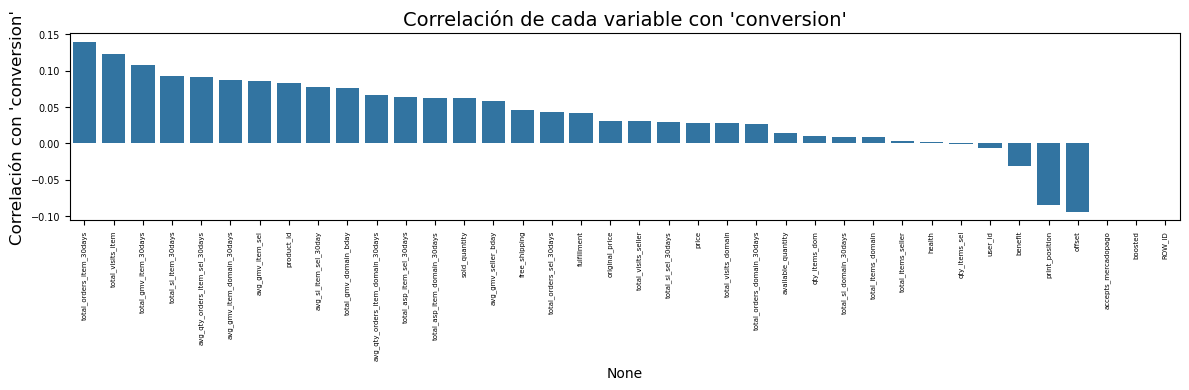

In [457]:
# Calcula la correlación de cada variable con 'conversion'
correlation_with_conversion = df.corr()['conversion'].drop('conversion').sort_values(ascending=False)  

# Crea un gráfico de barras para visualizar las correlaciones
plt.figure(figsize=(12, 4))
sns.barplot(x=correlation_with_conversion.index, y=correlation_with_conversion.values)
plt.xticks(rotation=90, fontsize=5)
plt.yticks(fontsize=7)
plt.ylabel("Correlación con 'conversion'", fontsize=12)
plt.title("Correlación de cada variable con 'conversion'", fontsize=14)
plt.tight_layout()
plt.show()

La presencia de valores nulos en el conjunto de datos es notable. Por ello, es esencial examinar la proporción de datos faltantes en cada variable. Esta revisión nos permitirá diseñar estrategias adecuadas para su manejo en las siguientes etapas del análisis.

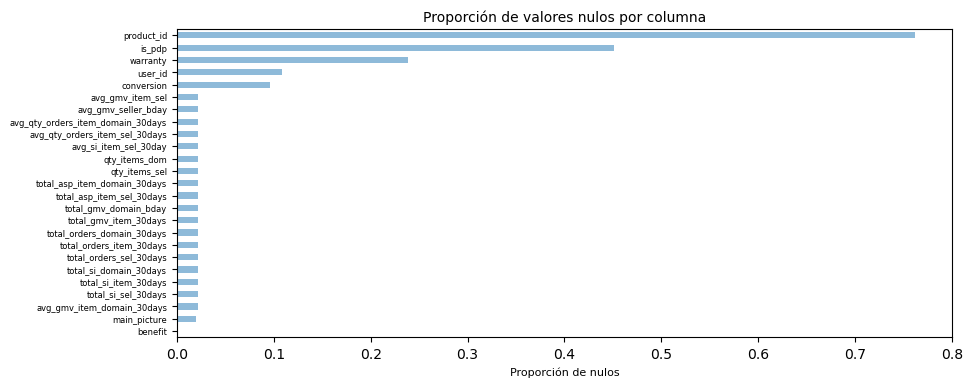

In [458]:
# Calcula la proporción de nulos para cada columna
null_proportion = df.isnull().mean()

# Eliminar 'row_id' de la serie
null_proportion = null_proportion.drop('ROW_ID', errors='ignore')

# Filtrar para mantener sólo las columnas con alguna proporción de nulos
null_proportion = null_proportion[null_proportion > 0]

# Ordenar en orden descendente
null_proportion = null_proportion.sort_values(ascending=True)

plt.figure(figsize=(10, 4))
null_proportion.plot(kind='barh', color='#8ebad9')
plt.title('Proporción de valores nulos por columna', fontsize=10)
plt.xlabel('Proporción de nulos', fontsize=8)
plt.yticks(fontsize=6)
plt.show()


## Eliminación de variables inutiles 

La descripcion del dataset determinaba algunas de las variables como invalidas, estas son:
<span> 
        <ul>
                <li><span style=color:lightblue> decimals</span></li>
                <li><span style=color:lightblue> etl_version</span></li>
                <li><span style=color:lightblue> rn</span></li>
        </ul>
</span>
Se eliminan de la base antes de continuar con el analisis.

In [459]:
df = df.drop(['benefit', 'etl_version'], axis=1)

Ademas, la variable <span style=color:lightblue> total_gmv_domain_bday </span> es una transformacion lineal de la variable total_gmv_domain_30days, por lo que tambien se elimina de la base.

In [460]:
df = df.drop(['total_gmv_domain_bday'], axis=1)

## Análisis de las variables numéricas

Comenzaremos analizando las variables numéricas que podrían no aportarnos valor a la predicción del modelo. 

In [461]:
df_num = df.select_dtypes(include='number')
df_bool = df.select_dtypes(include='bool')

#### Variables con un único valor

Notamos que las variables <span style=color:lightblue>accepts_mercadopago</span> y <span style=color:lightblue>boosted</span> contienen un unico valor posible. Por lo que lo unico que le aportará al modelo es tiempo computacional, que no queremos!

In [462]:
df = df.drop(columns=["accepts_mercadopago", "boosted"])

#### Combinación de Variables

##### Discount

Para finalizar el apartado del analisis de variables numericas, nos gustaria agregar una nueva columna que creemos significativa para predecir la conversión. Notamos que tenemos dos variables *original_price* y *price*. El ratio de las mismas podría encontranse significativo, chequeemos...

In [463]:
df["discount"] = (df["original_price"] - df["price"]) / df["original_price"]

Analicemos si *discount* presenta correlación con la conversión de los productos:

In [464]:
# Analizamos correlación entre discount (la nueva variable) y conversion
contingency_table = pd.crosstab(df['discount'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 23382.692434687342
P-value: 0.0


Un valor alto de Chi-cuadrado indica una discrepancia significativa entre las variables. Además, el valor p es 0.0, lo que significa que la probabilidad de obtener un valor de Chi-cuadrado tan alto (o más alto) bajo la suposición de independencia es esencialmente nula. Esto proporciona una fuerte evidencia en contra de la hipótesis nula de independencia y sugiere que las variables están correlacionadas.

Por la posibilidad de un sobreajuste del modelo guiado por tres variables correlacionadas decidimos eliminar las variables *price* y *original_price*.

In [465]:
df = df.drop(columns=["original_price", "price"])

### Analisis de Nulos

Es relevante mencionar que identificamos 4,365 registros con numerosos valores nulos en nuestro dataset. Aunque los modelos que empleamos gestionan eficazmente los valores nulos, optamos por explorar la imputación de estos mediante la media o la mediana. Sin embargo, esta estrategia no derivó en mejoras significativas, por lo que finalmente decidimos permitir que el modelo maneje los valores nulos directamente.


In [466]:
# %%capture
# mask = df_num["avg_gmv_item_domain_30days"].isna()
# del df_num
# df[mask]

Para que el analisis mantenga su consistencia se decide imputar los nulos presentados reemplazandolos por la mediana de la variable con los datos de entrenamiento. 
Las variables sobre las que se hara este proceso son:
- avg_gmv_item_domain_30days         
- avg_gmv_item_sel                  
- avg_gmv_seller_bday                
- avg_qty_orders_item_domain_30days  
- avg_qty_orders_item_sel_30days    
- avg_si_item_sel_30day 
- qty_items_dom                 
- qty_items_sel
- total_asp_item_domain_30days      
- total_asp_item_sel_30days     
- total_gmv_domain_bday            
- total_gmv_item_30day
- total_orders_domain_30days   
- total_orders_item_30days         
- total_orders_sel_30days      
- total_si_domain_30days         
- total_si_item_30days        
- total_si_sel_30days

In [467]:
# Valores Medianos
# columnas = ['avg_gmv_item_domain_30days', 'avg_gmv_item_sel','avg_gmv_seller_bday', 'avg_qty_orders_item_domain_30days', 'avg_qty_orders_item_sel_30days',    
#             'avg_si_item_sel_30day', 'qty_items_dom', 'qty_items_sel', 'total_asp_item_domain_30days', 'total_asp_item_sel_30days',     
#             'total_gmv_item_30days', 'total_orders_domain_30days', 'total_orders_item_30days', 'total_orders_sel_30days',      
#             'total_si_domain_30days', 'total_si_item_30days', 'total_si_sel_30days']
# for columna in columnas:
#     df[columna] = df[columna].fillna(df[df["ROW_ID"].isna()][columna].median()) 

La variable is_pdp tiene una gran proporción de nulos, por lo que se decide luego (apartado de enconding) hacer OHE separando is_pdp_true, is_pdp_false e is_pdp_nan ya que los valores que presentan la columna de is_pdp_nan NUNCA realizan la conversión como se muestra en la tabla.

In [468]:
df['is_pdp'] = df['is_pdp'].astype(str)

In [469]:
pd.crosstab([df['is_pdp']],df['conversion'])

conversion,0.0,1.0
is_pdp,,
False,82360,16532
True,391,212
nan,81266,0


In [470]:
df['is_pdp'].fillna('nan', inplace=True)

## Análisis las variables categoricas

In [471]:
df_categoricas = df.select_dtypes(include='object')

In [472]:
for column in df_categoricas:  
   print(column,":\f", df_categoricas[column].nunique()) 

category_id : 2284
date : 31
deal_print_id : 196744
domain_id : 1742
full_name : 2280
is_pdp : 3
item_id : 27695
listing_type_id : 2
logistic_type : 7
main_picture : 26961
platform : 4
print_server_timestamp : 196780
site_id : 1
tags : 1227
title : 26745
uid : 159996
warranty : 1288


#### Separación de variables temporales y de texto

Se separan las variables temporales:

- date
- print_server_timestamp

In [473]:
df_temporales = df[["date","print_server_timestamp"]]
df_categoricas = df_categoricas.drop(df_temporales, axis=1)

Se separan las variables de texto:

- full_name
- title
- tags

In [474]:
df_text = df[["full_name","title",'tags']]
df_categoricas = df_categoricas.drop(df_text, axis=1)

#### Plataform Engeneering

La variable *platform* se puede dividir ademas en si el usuario esta desde la web o mobile.

In [475]:
df['platform'].unique()

array(['/web/desktop', '/mobile/android', '/web/mobile', '/mobile/ios'],
      dtype=object)

In [476]:
df_categoricas['platform_web'] = df_categoricas['platform'].str.contains('web', case=False)

In [477]:
df = pd.concat([df,df_categoricas["platform_web"]], axis=1)

#### Variables con una unica categoria

Se elimina la variable porque solo tiene una categorica:

- site_id

In [478]:
df = df.drop('site_id', axis=1)

#### Logistic_type Engeneering

Se cree que el tipo de logistica no tiene una relacion natural con la variable resultado. Uno no decide si hacer una compra o no segun el tipo de logistica que utilice el comerciante para transportar su producto. Pero se procede a evaluar si existe una correlacion empirica. En caso de no haberla, se descartara la variable del analisis.

In [479]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['logistic_type'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 761.455399863375
P-value: 3.269950268794381e-161


En base a los resultados del Chi-cuadrado, podemos concluir que hay una correlación o asociación significativa entre las dos variables en estudio.

#### Main_picture Engeneering

La variable main_picture representa la imagen del producto, un factor que intuitivamente se percibe como crucial en la decisión de compra. Inicialmente, contemplamos la idea de diseñar una variable booleana que indicara la presencia o ausencia de una imagen. Sin embargo, al evaluar las correlaciones, nos dimos cuenta de que los valores nulos en main_picture no necesariamente se debían a productos sin imágenes, sino que podrían surgir de fallos en la recopilación de datos. Al explorar la plataforma de Mercado Libre, confirmamos que no se permite publicar productos sin imágenes, invalidando nuestra hipótesis inicial. Además, aunque intentamos diferentes técnicas de codificación, no logramos mejorar el rendimiento del modelo. Por ello, decidimos excluir main_picture como atributo en nuestro modelo final.

## Análisis de variables Temporales

Las variables temporales pueden influir mucho en el comportamiento del consumidor. Se debe evaluar y tener en cuenta el momento en el que estan visitando la pagina ya que puede determinar si se realiza o no la conversion. Es por eso que se realiza un encoding de estas variables.

In [480]:
# Modificamos el tipo de datos a datetime.
df["date"] = pd.to_datetime(df["date"])
df["print_server_timestamp"] = pd.to_datetime(df["print_server_timestamp"])
df[["date","print_server_timestamp"]]

,date,print_server_timestamp
0,2020-03-06,2020-03-06 00:19:30.735000-04:00
1,2020-04-01,2020-04-01 21:20:11.738000-04:00
2,2020-04-08,2020-04-08 18:38:48.360000-04:00
3,2020-04-25,2020-04-25 22:01:19.829000-04:00
4,2020-03-10,2020-03-10 13:20:56.633000-04:00
...,...,...
199967,2020-04-12,2020-04-12 14:35:44.784000-04:00
199968,2020-04-03,2020-04-03 17:32:53.035000-04:00
199969,2020-04-01,2020-04-01 22:51:08.898000-04:00
199970,2020-04-08,2020-04-08 11:32:27.563000-04:00


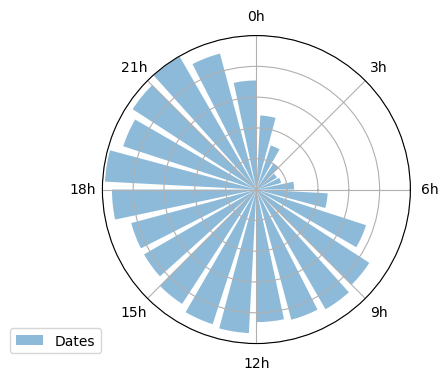

In [481]:
time_segment = 'hour'  
freq_arr, times = pycircular.utils.freq_time(df["print_server_timestamp"] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment, figsize=(4, 4))
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Combinando las funciones seno y coseno podemos caracterizar una variable cíclica. Esto se simula de esta manera para que las variables tengan un sentido ciclico y no lineal. Por ejemplo, en el caso de las horas la hora 00 y la hora 23 en la realidad estan muy cerca una de la otra. Si se las analiza linealmente perderian esta propiedad, pero si se les hace un encoding calculando sus seno y coseno se mantendria. 
Se realizara este analisis con las horas, los dias de la semana y los dias del mes.
No se realiza sobre el mes porque solo hay dos meses.

#### Para las horas:

In [482]:
# Unidad de tiempo:
cantidad_tiempo = 24

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))

df['hour_sin'] = seno
df['hour_cos'] = coseno


#### Para los dias de la semana:

In [483]:
# Unidad de tiempo:
cantidad_tiempo = 7

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))

df['weekday_sin'] = seno
df['weekday_cos'] = coseno

#### Para los dias del mes:

In [484]:
# Como solo hay mes 3 y 4 aplicamos una regla para determinar la cantidad de dias en cada uno de los meses:
df["days_in_month"] = df["print_server_timestamp"].dt.month.apply(lambda x: 31 if x == 3 else 30)

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))
coseno = np.cos((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))

df['day_sin'] = seno
df['day_cos'] = coseno

df = df.drop(columns = ["days_in_month"])


In [485]:
df = df.drop(columns = ["date","print_server_timestamp"])

## Análisis de variables de texto

In [486]:
df_text.columns

Index(['full_name', 'title', 'tags'], dtype='object')

In [487]:
# Eliminar los espacios enfrente y atras de las variables.
df_text = df_text.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Le saco las tildes a la base:
df_text = df_text.applymap(lambda x: unidecode(x) if isinstance(x, str) else x)
# Lo convierto a minusculas
df_text = df_text.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# Le saco los espacios dobles.
df_text = df_text.applymap(lambda x: x.replace('  ',' ') if isinstance(x, str) else x)

#### Name

<span style=color:red>Se opto por no utilizar la variable porque no se encontro una forma de analizarla que aporte valor al modelo.</span>

En el caso de *full_name* se extrae la primer categoria:

In [488]:
# df_text['name'] = df_text['full_name'].str.split('-', n=1).str[0]

In [489]:
# df_text.loc[df_text['name'] == 'eletrodomesticos ', 'name'] = 'electrodomesticos ' 
# df_text.loc[df_text['name'] == 'esportes e fitness ', 'name'] = 'deportes y fitness ' 
# df_text.loc[df_text['name'] == 'celulares y telefonia ', 'name'] = 'celulares y telefonos ' 
# df_text.loc[df_text['name'] == 'electrodomesticos y aires ac. ', 'name'] = 'electrodomesticos ' 
# df_text.loc[df_text['name'] == 'ropa, bolsas y calzado ', 'name'] = 'ropa y accesorios ' 

In [490]:
# df_text['name'].nunique()

Como son 27 clases, se podria realizar un Encoding sobre esta variable.

In [491]:
# # Analizamos correlación entre name y conversion
# contingency_table = pd.crosstab(df_text['name'], df['conversion'])
# chi2, p, dof, expected = chi2_contingency(contingency_table)

# print("Chi-square:", chi2)
# print("P-value:", p)

Basándonos en estos resultados, podemos concluir que hay una correlación significativa entre las dos variables en estudio.

In [492]:
# df_categoricas['name'] = df_text['name']

Agregamos la columna a df:

In [493]:
# df = pd.concat([df,df_categoricas["name"]], axis=1)
# df = df.drop(['full_name'], axis = 1) 

#### Tags

En el caso de los tags, son etiquetas que se le asignan al producto dentro de un rango de opciones. Por los que se puede hacer un encoding de si presenta o no esa etiqueta.

In [494]:
# Eliminar las llaves
df_text['tags'] = df_text['tags'].str.replace('[\[\]]', '', regex=True)

In [495]:
# Dividir las etiquetas en listas y luego codificarlas en variables binarias
tags_encoded = df_text['tags'].str.get_dummies(sep=', ')

# Agregar las variables binarias al DataFrame original
df_text = pd.concat([df_text, tags_encoded], axis=1)

In [496]:
df = df.drop(['tags'], axis = 1) 

#### Title

<span style=color:red>Se opto por no utilizar la variable porque no se encontro una forma de analizarla que aporte valor al modelo.</span>

#### Warranty Engeneering

Para continuar con el analisis notamos que la variable *warranty* es de tipo objeto pero en realidad esta detallando si tiene garantia (cuanto tiempo) o no. Por lo tanto, intentaremos modificar esa variable y analizaremos la garantía de los productos tiene o no una correlación con la conversión.

Primero se formatea para intentar sacar la mayor cantidad de duplicados:

- Convertir a Minusculas
- Eliminar tildes y caracteres especiales
- Eliminar espacios dobles
- Eliminar espacios al principio y al final de la oración.

In [497]:
# Eliminar los espacios enfrente y atras de las variables.
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.strip() if isinstance(x, str) else x)
# Le saco las tildes a la base:
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)
# Lo convierto a minusculas
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.lower() if isinstance(x, str) else x)
# Le saco los espacios dobles.
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.replace('  ',' ') if isinstance(x, str) else x)

In [498]:
def categorizar_garantia(garantia):
    garantia = str(garantia)
    if ("fabrica" in garantia) or ('marca' in garantia):
        return "garantia de fabrica"
    elif "vendedor" in garantia:
        return "garantia del vendedor"
    elif "sin garantia" in garantia:
        return "sin garantia"
    elif ('hora' in garantia) or ('hs' in garantia) or ('dia' in garantia) or ('mes'in garantia) or ('ano' in garantia) or ('vida' in garantia) or ('garantizamos' in garantia) or ('gtia' in garantia) or ('garantia' in garantia) or ('si' in garantia):
        return 'garantia'
    else:
        return "sin garantia"

In [499]:
# Aplica la función a la columna "garantia"
df_categoricas["cat_warranty"] = df_categoricas["warranty"].apply(categorizar_garantia)

In [500]:
df_categoricas["cat_warranty"].value_counts()

garantia de fabrica      77399
sin garantia             72952
garantia del vendedor    37228
garantia                 12393
Name: cat_warranty, dtype: int64

Analicemos la correlación de la variable *warranty* con la variable *conversion*:

In [501]:
# Analizamos correlación entre cat_warranty y conversion
contingency_table = pd.crosstab(df_categoricas['cat_warranty'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 126.2365510005184
P-value: 3.499566183925306e-27


A partir de el analisis de correlación (Chi cuadrado) notamos que existe una asociación significativa entre las dos variables categóricas. Por lo que la utilizaremos en el modelo para estimar la probabilidad de conversion.

In [502]:
df = pd.concat([df,df_categoricas["cat_warranty"]], axis=1)
df = df.drop(['warranty'], axis = 1) 

## Encoding

Procedemos a analizar las variables categoricas:

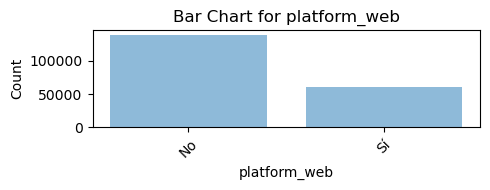

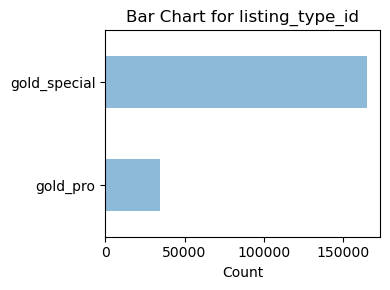

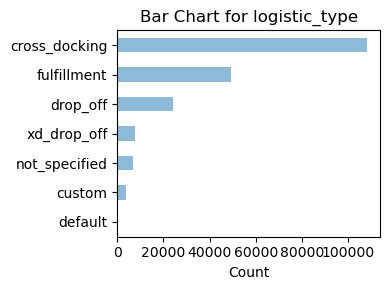

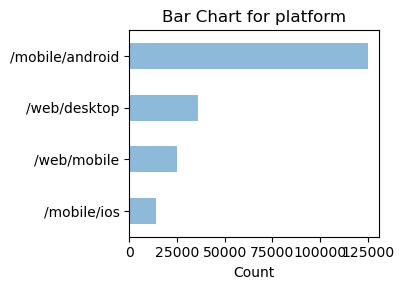

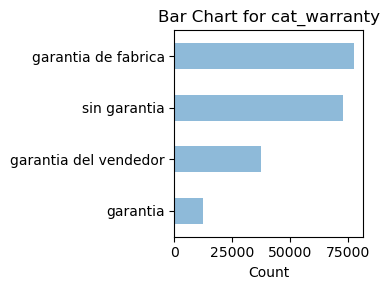

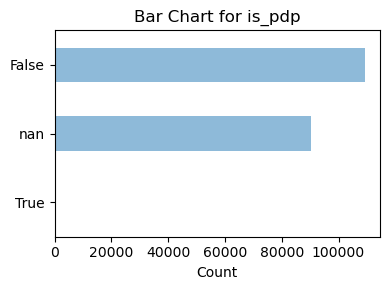

In [503]:
# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas[['platform_web']]:  
    categories = df_categoricas[column].value_counts().index
    values = df_categoricas[column].value_counts().values
    

    plt.figure(figsize=(5, 2))  # Tamaño del gráfico (opcional)
    plt.bar(categories, values, color=['#8ebad9'])
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.xticks([0, 1], ['No', 'Sí']) 
    plt.tight_layout()  # Ajustar el diseño
    plt.show()

# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas[["listing_type_id","logistic_type", "platform",'cat_warranty', 'is_pdp']]:  
    # Cuenta la frecuencia de cada especie y ordena de mayor a menor
    frecuencia = df_categoricas[column].value_counts().sort_values(ascending=True)

    # Crea un gráfico de barras horizontal
    plt.figure(figsize=(4, 3))  # Ajusta el tamaño si es necesario
    frecuencia.plot(kind='barh', color=['#8ebad9'])  # Usa 'barh' para gráfico de barras horizontal
    plt.xlabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.tight_layout()
    plt.show()

Como resulta significativa la prueba de chi-cuadrado, se concluye que la variable logistic_type presenta una correlacion empirica. Es por eso que se decide hacer OneHotEncoding con la misma.

Quisimos probar diferentes tipos de tecnicas de enconding en las variables categoricas. Para encontrar la mejor combinación
- OHE (One-Hot Encoding): conocido por las clases teoricas. 
- LE (Label Encoding): Asigna a cada categoría un valor numérico único, generalmente de 0 a N-1, donde N es el número de categorías.
- OE (Ordinal Encoding): Similar al Label Encoding, pero se utiliza específicamente para variables categóricas que tienen un orden inherente.
- FE (Frequency Encoding): Codifica las categorías basadas en la frecuencia o proporción de observaciones que tienen esa categoría.
- TE (Target Encoding) o Mean Encoding: Basado en la relación entre la categoría y el objetivo (target).

Las variables booleanas ya tienen Encoding.

- picture
- platform_web

En el resto de variables categoricas se evalua que tipo de encoding es el mas eficiente:

- category_id
- domain_id
- item_id
- listing_type_id
- logistic_type
- platform
- cat_warranty
- is_pdp

La mejor combinacion de tecnicas se vio al utilizar One Hot Encoding con las variables: 'listing_type_id', 'logistic_type', 'platform', 'cat_warranty', 'is_pdp' y Frecuency Encoding con las variables: 'category_id', 'domain_id', 'item_id', 'uid' y 'deal_print_id'.

##### One Hot Encoding:

In [504]:
# Definir las columnas a las que se aplicará One-Hot Encoding
columns_to_OHE = ['listing_type_id', 'logistic_type', 'platform', 'is_pdp', 'cat_warranty']

# Aplicar One-Hot Encoding a las columnas especificadas
df = pd.get_dummies(df, columns=columns_to_OHE, prefix=columns_to_OHE)

##### Frecuency Encoding:

In [505]:
# Definir las columnas a las que se aplicará Frequency Encoder
columns_to_FE = ['category_id', 'domain_id', 'item_id', 'uid', 'deal_print_id']

for col in columns_to_FE :
    fe = df[col].value_counts(normalize=True)
    df[col] = df[col].map(fe)

#### eliminación de variables a las que no se les encontro una ingeniera de features que mejore la performance del modelo

In [506]:
#borro variables categoricas no soportadas por xgb
df = df.drop(columns=["full_name", "main_picture", "title"])

## Split into tranining and evaluation samples:

- Train: 80%
- Val: 20%
- Test: de testeo.

In [507]:
df['print_position'].unique()

array([ 1717,   311,  1686, ..., 12369,  8003,  3968])

In [508]:
# Split into training and evaluation samples
train_data = df[df["ROW_ID"].isna()]
test_data = df[df["ROW_ID"].notna()]
del(df)

In [509]:
train_data = train_data.drop(columns=["ROW_ID"])
y_train = train_data['conversion']
X_train = train_data.drop(columns=["conversion"])
del train_data

In [510]:
X_test = test_data.drop(columns=["conversion", "ROW_ID"])

# Exploración e Implementación del Modelo 

Una vez finalizado el analisis exploratorio de datos (EDA), se procede a la exploracion e implementacion del modelo.

## XG Boost

### Modelo A con Random Search 


In [291]:
%%capture
model_xgb_A = XGBClassifier(n_jobs=3, use_label_encoder=False)

In [ ]:
%%capture
param_dist_A = {'max_depth': stats.randint(5,12),
              'learning_rate': stats.uniform(0.05, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

xgb_random_A = RandomizedSearchCV(model_xgb_A,param_dist_A, cv=cv, verbose=1, n_jobs=3, scoring='roc_auc', n_iter=40, random_state=15)
xgb_random_A.fit(X_train,y_train)

In [293]:
xgb_random_A.best_params_

{'colsample_bytree': 0.9488176972685787,
 'learning_rate': 0.13944796246049923,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 717,
 'subsample': 0.37540092860641194}

In [294]:
xgb_random_A.best_score_

0.8926095492736829

In [296]:
# Predict on the evaluation set
y_pred_A = xgb_random_A.predict_proba(X_test)[:,1]
y_pred_A

array([2.7422093e-02, 1.6784949e-04, 1.9484276e-01, ..., 7.9242403e-05,
       5.7960093e-02, 9.5754986e-05], dtype=float32)

In [297]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_A})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgb_A.csv", sep=",", index=False)

### Modelo A con Early Stopping

 Ahora utilicemos *early_stopping_rounds* a modo de que el modelo frene luego de que pasen 10 iteraciones en la que la performance no mejora. Este nos ayudará a intentar omitir el overfitting. 

In [307]:
%%capture
xgb_gs = XGBClassifier(n_jobs=3, use_label_encoder=False, early_stopping_rounds=10)

In [308]:
%%capture
# Definir la grilla de parámetros
param_grid = {
    'max_depth': [5, 6, 7], 
    'learning_rate': np.arange(0.05, 0.1),  
    # 'subsample': np.arange(0.1, 1.1), 
    # 'colsample_bytree': np.arange(0.3, 0.91, 0.1), 
    'min_child_weight': [1, 2], 
    'n_estimators': [500, 800, 1000]  
}

# Crear una instancia de StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

# Crear una instancia de GridSearchCV con tu modelo
xgb_gs = GridSearchCV(xgb_gs, param_grid, cv=cv, verbose=1, scoring='roc_auc')

# Ajustar el modelo utilizando GridSearchCV
xgb_gs.fit(X_train, y_train)

In [315]:
xgb_gs.best_params_

{'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 2,
 'n_estimators': 500}

In [316]:
xgb_gs.best_score_

0.9010810590622815

In [317]:
# Print the accuracy for each iteration
for i, score in enumerate(xgb_gs.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: roc_auc = {score:.4f}")

Iteraciones 1: roc_auc = 0.8991
Iteraciones 2: roc_auc = 0.9004
Iteraciones 3: roc_auc = 0.9008
Iteraciones 4: roc_auc = 0.8989
Iteraciones 5: roc_auc = 0.9005
Iteraciones 6: roc_auc = 0.9008
Iteraciones 7: roc_auc = 0.9004
Iteraciones 8: roc_auc = 0.9009
Iteraciones 9: roc_auc = 0.9010
Iteraciones 10: roc_auc = 0.9003
Iteraciones 11: roc_auc = 0.9009
Iteraciones 12: roc_auc = 0.9010
Iteraciones 13: roc_auc = 0.9009
Iteraciones 14: roc_auc = 0.9008
Iteraciones 15: roc_auc = 0.9004
Iteraciones 16: roc_auc = 0.9011
Iteraciones 17: roc_auc = 0.9010
Iteraciones 18: roc_auc = 0.9007


In [312]:
# Predict on the evaluation set
y_pred_gs = xgb_gs.predict_proba(X_test)[:,1]
y_pred_gs

array([3.8524393e-02, 2.5538660e-05, 9.2707030e-02, ..., 2.3452991e-05,
       8.4790356e-02, 1.7203331e-05], dtype=float32)

In [318]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_gs})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgb_gs.csv", sep=",", index=False)

#### Importancia de Variables

<Figure size 1200x3000 with 0 Axes>

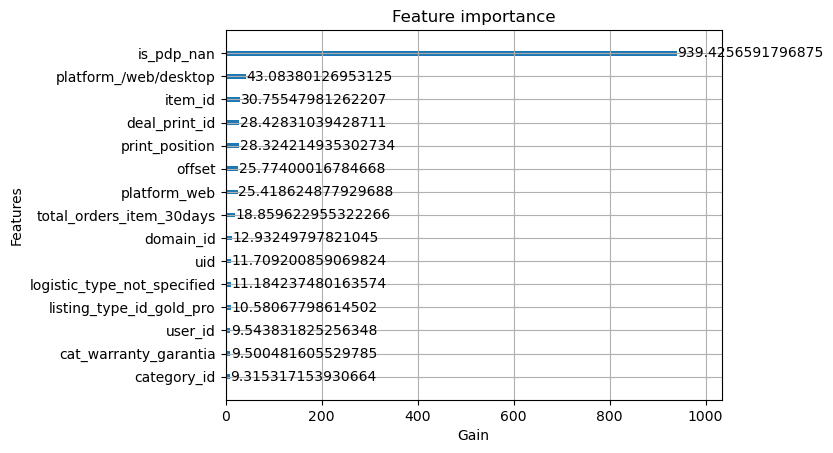

In [326]:
# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb = xgb_gs.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb, max_num_features=15,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

In [ ]:
# Predict on the evaluation set
y_pred_bp = xgb_bp.predict_proba(X_test)[:,1]
y_pred_bp

array([0.0415995 , 0.00029764, 0.15780479, ..., 0.00183079, 0.0584925 ,
       0.00018136], dtype=float32)

In [ ]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_bp})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgb_bp.csv", sep=",", index=False)

## Random Forest

In [ ]:
# N_TREES = 100

# # Definición de la función objetivo para Hyperopt
# def objective(params):
#     tree = DecisionTreeClassifier(**params, random_state=2345)
#     tree.fit(X_train, y_train)
#     y_preds_val_prob = tree.predict_proba(X_val)[:, tree.classes_ == True]
#     score = roc_auc_score(y_val, y_preds_val_prob)
#     return {'loss': -1 * score, 'status': STATUS_OK}

# # Espacio de búsqueda para los hiperparámetros
# space = {'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
#          'splitter': hp.choice('splitter', ['best', 'random']),
#          'max_depth': hp.uniformint('max_depth', 5, 12),
#          'min_samples_split': hp.uniformint('min_samples_split', 2, 20),
#          'min_samples_leaf': hp.uniformint('min_samples_leaf', 1, 20),
#          'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.1)}

# # Búsqueda de hiperparámetros óptimos con Hyperopt
# best = fmin(objective, space,
#             algo=tpe.suggest,
#             max_evals=N_TREES,
#             rstate=np.random.default_rng(3456)) 
# best_tree_params = space_eval(space, best)

# # Entrenamiento y evaluación del modelo Random Forest
# rf = RandomForestClassifier(n_estimators=N_TREES, n_jobs=-1, verbose=1, oob_score=True)
# rf.fit(pd.concat([X_train, X_val], axis=0),
#        pd.concat([y_train, y_val], axis=0))

Obtenemos el siguiente score:

In [ ]:
# rf.oob_score_

## LGBM

In [327]:
# Parámetros para LGBM
param_dist = {
    'num_leaves': stats.randint(6, 50), 
    'min_child_samples': stats.randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': stats.uniform(loc=0.2, scale=0.8), 
    'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
    'n_estimators': stats.randint(1000, 2000)
}

In [328]:
# Crear modelo LGBM
clf = lgbm.LGBMClassifier(max_depth=-1, random_state=45, metric='None', n_jobs=-1, class_weight='balanced', 
                         scale_pos_weight = sum(y_train == 0) / sum(y_train == 1), boost_from_average=False)

In [329]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [330]:
%%capture
# Búsqueda aleatoria
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=skf, scoring='roc_auc', n_jobs=-1, random_state=29)
random_search.fit(X_train, y_train)

In [336]:
random_search.best_params_

{'colsample_bytree': 0.9971327580850708,
 'min_child_samples': 479,
 'min_child_weight': 100.0,
 'n_estimators': 1205,
 'num_leaves': 29,
 'reg_alpha': 5,
 'reg_lambda': 50,
 'subsample': 0.7770995596800685}

In [337]:
random_search.best_score_

0.9006623448260989

In [452]:
# Predict on the evaluation set
y_predd = random_search.predict_proba(X_test)[:,1]
y_predd

array([2.05810241e-01, 1.87109087e-04, 6.61335945e-01, ...,
       6.22113760e-04, 7.44569931e-01, 1.37224296e-05])

In [453]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_predd})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("lgbm.csv", sep=",", index=False)

#### Importancia de Variables

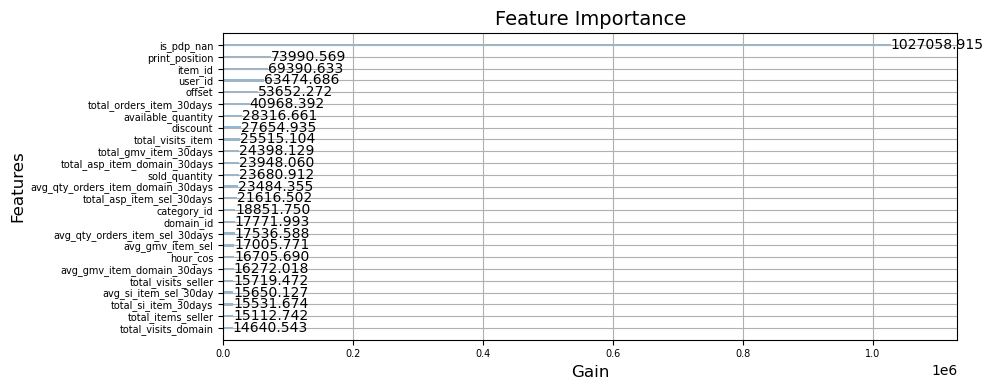

In [454]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Suponiendo que model ya es un LGBMClassifier
lgb.plot_importance(model, max_num_features=25, importance_type="gain", xlabel="Gain", figsize=(10, 4), color='#8ebad9')

# Ajustar el tamaño de los textos
plt.title("Feature Importance", fontsize=14)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.xlabel("Gain", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()
